Tanner, Noah\
HW 0x03 Systems Modeling\
ME 405 - Professor Refvem\
Fall 2023

HW 0x03 Systems Modeling
ME 405 - Professor Refvem
Fall 2023

In [73]:
from numpy import array, arange, zeros, transpose
from matplotlib import pyplot, rc
from math import pi, cos, sin

Systems Model:\
\
In order to model the Romi robot system as a differential drive robot, and not a "unicycle" model, the independent characteristics of each wheel must be considered. In the image below, there is an independent velocity vector for the left and right wheels, as well as a combined velocity vector that makes up the velocity at a central point, inbetween the two wheels. The two coordinate systems, X,Y (Global), and X_R, Y_R (Local to the robot) are also pictured.
\
<img src="./Model_Pic.png" alt="Diagram of Romi Model" style="height:300px;" />
\
Some variables have been defined as well in order to understand the equations.
\
\
𝜔_r = Angular velocity of right wheel (rad/s)\
𝜔_l = Angular velocity of left wheel (rad/s)\
R       = Radius (R_r = R-l = R, unless otherwise noted)\
L       = Distance between the two wheels (Radius of rotation)

The following differential equations reflect the dynamics associated with a two wheel, differential drive robot. 

$$
\begin{array}{rl}
\frac{d}{dt}X           &= \left( \frac{R}{2} \left( \omega_r + \omega_l \right) 
\cos\theta \right)\\
\frac{d}{dt}Y           &= \left( \frac{R}{2} \left( \omega_r + \omega_l \right) 
\sin\theta \right)\\
\frac{d}{dt}\theta      &= \left( \frac{R}{L} \left( \omega_r + \omega_l \right) 
\right)
\end{array}
$$

Combining the preceding equations, a single vector equation can be obtained that can be solved using vector based ODE solution techniques.

$$
\begin{array}{rl}
\frac{d}{dt}
    \begin{bmatrix}
        X \\
        Y \\
        \theta
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{R}{2} \left( \omega_r - \omega_l \right)cos \theta \\
    \frac{R}{2} \left( \omega_r - \omega_l \right)sin \theta \\
    \frac{R}{L} \left( \omega_r - \omega_l \right)
\end{bmatrix} \\

\end{array}
$$



In [74]:
# mechanical properties
R       = 2.83 / 2          # radius of wheel [ in ]
L       = 4.92 /2           # distance between the two wheels [ in ]

# input radius and desired tangential speed of robot
rad = 4 
vel  = 2

In [75]:
def system_eqn_ol(t, x):
    '''!@brief      Implements both state equations and output equations for the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector and the output
                    vector for a given simulation step
    '''
    
    # take input velocity and circle radius and back solve for angular velocity of romi
    omg_romi = vel / rad
    # set theta equal to the final value in the output array for each solved iteration
    theta = x[2]
    
    # calculate anuglar velocities of left and right wheel based off of romi angular velocity
    omg_r = (vel + (omg_romi*L)) / rad
    omg_l  = (vel - (omg_romi*L)) / rad
    
    xd = array([    [ (R/2) * cos(theta) * (omg_r + omg_l) ],
                    [ (R/2) * sin(theta) * (omg_r + omg_l) ],
                    [ omg_romi ] ])

    # y = [ x, y, theta ]
    y     = array([ [x[0]],
                    [x[1]],
                    [x[2]] ])

    return xd, y

## Runge-Kutta Method (4th order)
The Runge-Kutta Method is the method of solving used in this homework as the integration technqiue is fourth order, allowing for a smaller truncation error for a given step size. This allows for a more reasonable step size while maintaining the reasonable accuracy of the solution. The algoritihm is similar to Euler's method, however it splits the window of time, $\Delta t$ in half, and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is the used in a standard Euler step. 
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n) \\
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t).
\end{array}
$$

In [76]:
def ruku4(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a fourth order runge-kutta solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    # define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])

    # determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])

    # preallocate an array of zeros to store output values
    yout = zeros([len(tout),r])
    
    # initialize output array with initial state vecotr
    xout[0][:] = x_0.T

    # iterate through algorithim, but stop one cycle early as the algorithim predicts one cycle ahead
    for n in range(len(tout)):
        
        # pull our a row from the solution array and transpose to get state vector as column
        x = xout[[n]].T

        # pull out the present value of time
        t = tout[n]

        # evaluate the f(n) handle at the preszent time with the present value of the state vector to compute the derivate
        k1, y = fcn( t, x )
        k2, y = fcn( t+.5*tstep, x+.5*k1*tstep )
        k3, y = fcn( t+.5*tstep, x+.5*k2*tstep )
        k4, y = fcn( t+tstep,    x+k3*tstep )
        
        # apply the update rule for RK4 method
        xout[n+1]   = xout[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4).T*tstep
        yout[n]     = y.T

    return tout, yout

## Run and Plot OL Results

/var/folders/pr/s3g8npxs1yz71_4wv_ktx_xw0000gn/T/ipykernel_28404/2285024505.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xd = array([    [ (R/2) * cos(theta) * (omg_r + omg_l) ],
/var/folders/pr/s3g8npxs1yz71_4wv_ktx_xw0000gn/T/ipykernel_28404/2285024505.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [ (R/2) * sin(theta) * (omg_r + omg_l) ],


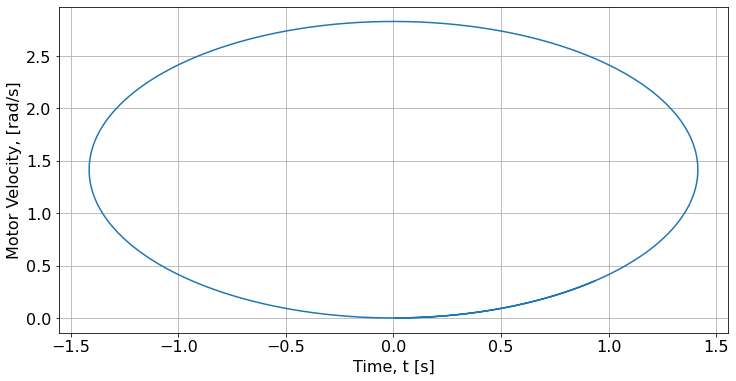

In [77]:
# initial conditions
x_0 = array([ [0],
              [0],
              [0] ])
# Solve the open loop system over a 0.1 second time window with 1 ms steps
t_OL, y_OL = ruku4(system_eqn_ol, x_0, [0, 14], 1e-2)

# Enlarge font size
rc('font', **{'size'   : 16})

pyplot.figure(figsize=(12,6))
pyplot.plot(y_OL[:,0], y_OL[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Motor Velocity, [rad/s]')
pyplot.grid()